# Языковое моделирование
Всем снова привет! Сегодня я нашел на ютубе <a href="https://www.youtube.com/watch?v=KOIEozoCQo0&t=113s">ВИДЕО</a> семинара из замечательного ФИЗТЕХа по машинному обучению в плане нейронной сети. Просто увидел, просто зашел, просто повторил чтобы проверить и понять. Поэтому давайте сегодня разберемся с интересной задачей, и ее реализацией.

---
## Задача
Суть в том, что необходимо создать программу, которая будет генерировать имена. У нас имеется только датасет с различными английскими именами, и на их основе нейронка будет создавать уже свои имена, которых может и не существовать на свете. <a href="https://www.youtube.com/watch?v=KOIEozoCQo0&t">(*Ссылка на семинар МФТИ*)</a>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wget
%matplotlib inline

В нашем датасете имеется порядка 8000 имен, в результате которого мы сможем создавать различные имена для чего угодно.
К примеру, похожая нейронная сеть используется для создания неограниченного количества названий игрушек в IKEA, во многих играх при выборе персонажа

Я же думаю, что если вдруг я захочу написать новеллу большую, и не захочу думать над именами для нее, то я просто воспользуюсь этой нейронкой чтобы сразу и быстро подобрать имена

In [2]:
wget.download('https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/week0_09_embeddings_and_seq2seq/names', 'names.txt') # Скачал с сайта информацию в txt файл

'names (4).txt'

In [3]:
import os
start_token = " "
with open("names.txt") as f: # Из txt файла записываем построчно значения
    names = f.read()[:-1].split('\n') # все кроме последней строчки (последняя строчка это пустая строка в файле)
    names = [start_token + line for line in names] # добавили пробел перед именами

In [4]:
print ('n samples = ',len(names))
for x in names[::1000]:   # каждое тысячное вывести
    print (x)


n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


Как видите, мы создали список имен names.
Давайте посмотрим на распределение длин наших имен

Максимальная длина слова = 16


Text(0, 0.5, 'Количество имен')

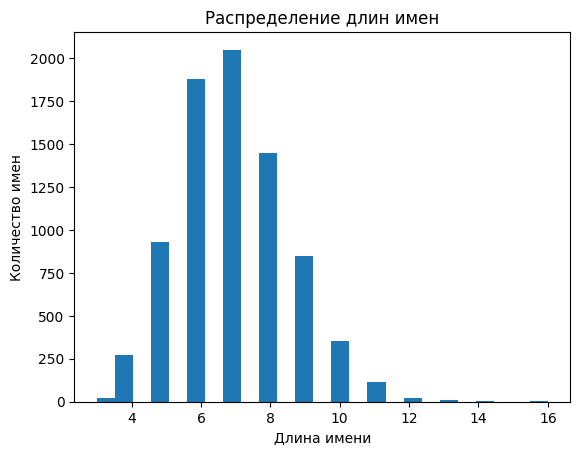

In [5]:
MAX_LENGTH=max(map(len,names)) # map применяет операцию len к каждому элементу списка 
print(f"Максимальная длина слова = {MAX_LENGTH}")
plt.title('Распределение длин имен')
plt.hist( list(map(len,names)),bins=25);
plt.xlabel('Длина имени')
plt.ylabel('Количество имен')

Как видите, наш график чем-то напоминает гауссово распределение, только правый хвост вытянут

Теперь, мы с вами теперь работаем с текстами. Любая последовательность текста у нас есть в датасете. Давайте найдем теперь все уникальные токены наших имен.

In [6]:
set(names[0])

{' ', 'A', 'a', 'b', 'e', 'g', 'l'}

In [7]:
print('Как видите, мы смотрим сейчас все уникальные токены (символы) которые у нас есть в первой строчке.\nТакже здесь есть некоторые двойные имена, будут и знаки препинания, запятые и тд')

Как видите, мы смотрим сейчас все уникальные токены (символы) которые у нас есть в первой строчке.
Также здесь есть некоторые двойные имена, будут и знаки препинания, запятые и тд


In [8]:
tokens= set()
for name in names:
    tokens.update(set(name)) # создали хеш таблицу в питоне
print("Метод .update дополняет словарь, дополняя его новыми значениями")
tokens = list(tokens) # преобразуем в list чтобы он был упорядоченный
print(tokens)
print(f"Длина нашего списка символов: {len(tokens)}")
num_tokens=len(tokens)
assert 50<len(tokens)<60, "Имена должны иметь от 50 до 60 уникальных символов для декодирования"

Метод .update дополняет словарь, дополняя его новыми значениями
['v', 't', 'b', 'g', '-', "'", 'W', 'Y', 'C', 'n', 'R', 'p', 'y', 'V', 'x', 'z', 'A', 'f', 'm', 'j', 'M', 'e', 'H', 'X', 'U', 'G', 'k', 'J', 'Z', 'T', 'B', 'q', ' ', 'K', 'S', 'D', 'i', 'h', 'L', 'O', 'c', 'r', 'I', 'E', 'P', 's', 'N', 'a', 'Q', 'o', 'F', 'w', 'u', 'l', 'd']
Длина нашего списка символов: 55


## Преобразование символов в целые числа

---
метод Torch создан для обработки чисел, а не строк. Чтобы обучить нашу нейронную сеть, нам нужно будет заменить символы их индексами в списке токенов.

Давайте составим словарь, который выполняет это сопоставление.

In [9]:
tokens.append('<') #Символ начала строки/ <SOS>
tokens.append('>') #Символ конца строки/ <EOS>
tokens.append('_') #Символ пад токена/ <PAD>

In [10]:
token_to_id={token:idx for idx,token in enumerate(tokens)}
token_to_id

{'v': 0,
 't': 1,
 'b': 2,
 'g': 3,
 '-': 4,
 "'": 5,
 'W': 6,
 'Y': 7,
 'C': 8,
 'n': 9,
 'R': 10,
 'p': 11,
 'y': 12,
 'V': 13,
 'x': 14,
 'z': 15,
 'A': 16,
 'f': 17,
 'm': 18,
 'j': 19,
 'M': 20,
 'e': 21,
 'H': 22,
 'X': 23,
 'U': 24,
 'G': 25,
 'k': 26,
 'J': 27,
 'Z': 28,
 'T': 29,
 'B': 30,
 'q': 31,
 ' ': 32,
 'K': 33,
 'S': 34,
 'D': 35,
 'i': 36,
 'h': 37,
 'L': 38,
 'O': 39,
 'c': 40,
 'r': 41,
 'I': 42,
 'E': 43,
 'P': 44,
 's': 45,
 'N': 46,
 'a': 47,
 'Q': 48,
 'o': 49,
 'F': 50,
 'w': 51,
 'u': 52,
 'l': 53,
 'd': 54,
 '<': 55,
 '>': 56,
 '_': 57}

In [11]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


теперь мы будем брать сразу несколько последовательностей, и после этого будем их обрабатывать (разделяя их пробелом)

In [12]:
def to_matrix(names, max_len=None, pad=token_to_id['_'], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    max_len= max_len or max(map(len,names))
    max_len +=1
    names_ix = np.zeros([len(names),max_len],dtype) +pad 
    names_ix[:,0]=token_to_id['<'] #SOS
    #print(f"Начальная матрица:\n{names_ix}")
    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, 1:len(line_ix)] = line_ix[1:]
        names_ix[i, len(line_ix)] = token_to_id[">"]
    return names_ix
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

In [13]:
#Пример: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[55 16  2 47  3 47 21 53 56 57]
 [55 25 53 49 41 12 56 57 57 57]
 [55 44 41 36 45 45 36 21 56 57]
 [55 25 36 49  0 47  9  9 21 56]]


Как теперь вы видите, данная функция строит так называемую карту с id символов, которые лежат в матрице. Размер матрицы зависит от максимальной длины среди имен.
Если какое-то слово имеет длину меньше чем  максимума, то заполняются только те ячейки, которые содержат какие-то символы, остальные изначально выставляются как пробелы с id=9,
которые всегда можно будет убрать позже. Это называется pad токенами, и они как раз задаются в функции. Круто) Поехали дальше

Также мы специально добавляем токены начала и конца строки, чтобы можно было легко и быстро определять границы строки, чтобы дальше мы не считывали строку

Text(0.5, 1.0, 'Знак начала строки SOS')

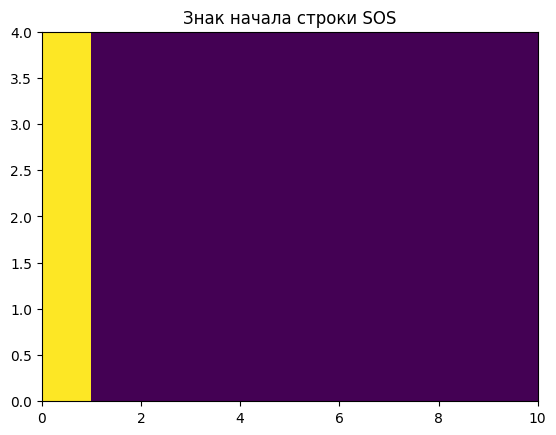

In [14]:
plt.pcolormesh(to_matrix(names[::2000])==55)
plt.title("Знак начала строки SOS")

Text(0.5, 1.0, 'Знак конца строки EOS')

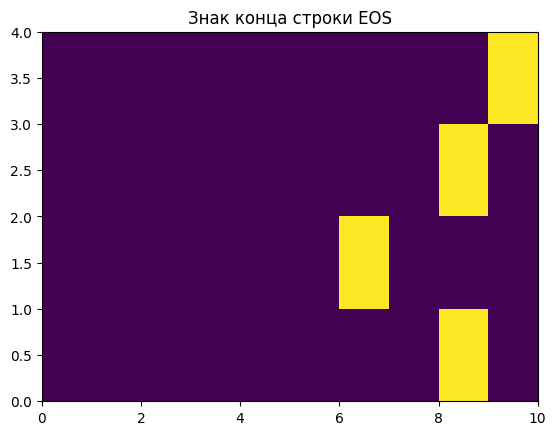

In [15]:
plt.pcolormesh(to_matrix(names[::2000])==56)
plt.title("Знак конца строки EOS")

Text(0.5, 1.0, 'Знак PAD')

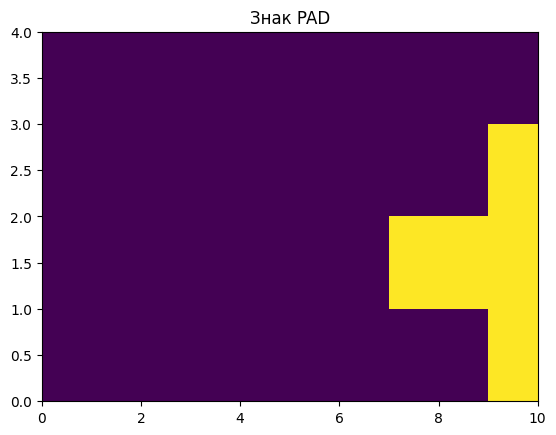

In [16]:
plt.pcolormesh(to_matrix(names[::2000])==token_to_id["_"])
plt.title("Знак PAD")

Ну и давайте проверим что у нас всё корректно, отобразив информацию строки снова в символьном варианте

In [17]:
for i in range(4):
    print(''.join([tokens[idx] for idx in to_matrix(names[::2000])[i]]))

<Abagael>_
<Glory>___
<Prissie>_
<Giovanne>


# Рекуррентная нейронная сеть

Мы можем переписать рекуррентную нейронную сеть как последовательное применение плотного слоя для ввода $x_t$ и предыдущего состояния rnn $h_t$. Это именно то, что мы сейчас и собираемся сделать.

<img src="./rnn.png" width=480>

Поскольку мы обучаем языковую модель, также должны быть:
* Слой встраивания, который преобразует идентификатор символа x_t в вектор.
* Выходной слой, который предсказывает вероятности следующей фонемы

In [18]:
import torch, torch.nn as nn
import torch.nn.functional as F


c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Рассмотрим пример для оперции Embedding
embed=nn.Embedding(4,2) # 4 уникальный токена отображаем в 2х-мерное пространство
next(embed.parameters())

Parameter containing:
tensor([[ 1.1439,  1.1410],
        [ 1.0509,  0.4999],
        [-0.9100, -0.2414],
        [-0.4943,  1.1007]], requires_grad=True)

Подробнее про Эмбеддинг можете прочитать тут: <a href="https://habr.com/ru/company/wunderfund/blog/590651/"> ССЫЛКА </a>

А так могу сказать, что таким методом можно сразу заставить машине составлять матрицу весов, но и использовать наши токены в векторном виде, чтобы потом можно было исходя из вектора научить машину предсказывать слово для минимизации ошибок и размерности матриц (Как видите, изначально у нас было 55 различных символов, а мы их представили в виде 16мерного вектора (embedding_size=16). Таким образом вычисления уменьшаться в десятки раз за счет небольшой потери качества)

In [24]:
class CharRNNCell(nn.Module): 
    """
    Здесь мы будем реализовать одиночный слой, который по итогу будет крутиться раз за разом
    __init__ - конструктор
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size) # Соответствущему индексу выбирает нужную матрицу весов для создания нужного выходного вектора
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        Этот метод вычисляет h_next(x, h_prev) и log P(x_next | h_next)
        Мы будем вызывать его несколько раз, чтобы создать всю последовательность целиком.
        
        :param x: пакет идентификаторов символов, содержащий вектор int64
        :param h_prev: предыдущие скрытые состояния rnn, содержащие матрицу [batch, rnn_num_units] float32
        """
        # получаем векторное вложение embedding x
        x_emb = self.embedding(x) 
        
        # вычислим следующее скрытое состояние, используя self.rnn_update
        # подсказка: использовать будем torch.cat (..., dim=...) для объединения

        x_and_h = torch.cat([x_emb,h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #вычислим логиты для следующих символьных проб, используя линейный классификатор
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [27]:
hyperparams = {
    'depth':11,
    'lengh': 24
}
char_rnn = CharRNNCell()
print(char_rnn)

CharRNNCell(
  (embedding): Embedding(58, 16)
  (rnn_update): Linear(in_features=80, out_features=64, bias=True)
  (rnn_to_logits): Linear(in_features=64, out_features=58, bias=True)
)


### Цикл RNN

Как только мы определили один шаг RNN, мы можем применить его в цикле, чтобы получить прогнозы на каждом шаге.

In [29]:
def rnn_loop(char_rnn, batch_ix):
    """
    вычисляет логарифм вероятности следующего токена
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [31]:
num_tokens=len(tokens)

In [40]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logit_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

### Вероятность и градиенты

Теперь мы можем обучить нашу нейронную сеть минимизировать перекрестную энтропию (максимизировать логарифмическую вероятность) с помощью фактических следующих токенов.

Чтобы сделать это векторизованным образом, мы берем `batch_ix[:, 1:]` - матрицу идентификаторов токенов, сдвинутую на i шаг влево, так что i-й элемент фактически является "следующим токеном" для i-го прогноза

In [41]:
predictions_logits = logit_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# logp_next = torch.gather(
#     predictions_logp,
#     dim=2, 
#     index=actual_next_tokens[:,:,None]
#     )

# loss = -logp_next.mean()

In [42]:
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id['_'])
loss2 = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )

In [43]:
loss2.backward()

In [44]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

### Тренировочный цикл

Мы обучаем наш char-rnn точно так же, как мы обучаем любую модель глубокого обучения: с помощью мини-пакетного sgd.

Единственное отличие заключается в том, что на этот раз мы сэмплируем строки, а не изображения или звук.

In [36]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

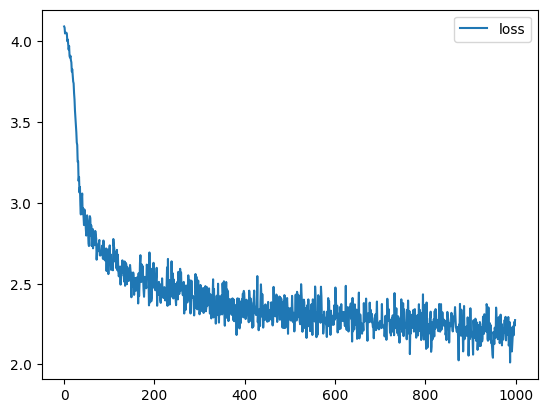

In [45]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logits_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )
    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: выборка
Как только мы немного натренируем нашу сеть, давайте приступим к фактическому созданию материала. 
Все, что нам нужно, это функция single rnn step, которую вы определили в `char_rnn.forward`.

In [56]:
def generate_sample(char_rnn, seed_phrase='<', max_length=MAX_LENGTH, temperature=1.0):
    '''
   Функция генерирует текст, заданный фразой длиной не менее SEQ_LENGTH.
    :параметр seed_phrase: Начало имени. RNN просят продолжить фразу
    :параметр max_length: максимальная длина вывода, включая начальную фразу
    :temperature параметр: коэффициент для отбора проб.  более высокая температура приводит к более хаотичным выходам,
    меньшая температура сходится к единственному наиболее вероятному выходу
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        if next_ix == token_to_id['>']:
          break
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [48]:
def softmax(x, temp=1.):
  exps = np.exp((x - x.max()) / temp)
  return exps / exps.sum()

<BarContainer object of 5 artists>

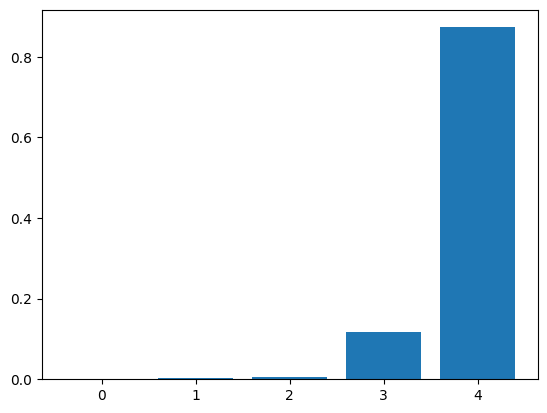

In [49]:
plt.bar(np.arange(5), softmax(np.array([1, 3 , 4, 7, 9]), 1))

In [60]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=0.1)[1:-1])

Marina
Carina
Marie
Marina
Carina
Marine
Carina
Marine
Carina
Marina


In [70]:
for _ in range(15):
    print(generate_sample(char_rnn, seed_phrase='<Ser'))

<Serayna>
<Seryinn>
<Seril>
<Serik>
<Serline>
<Sermale>
<Serelel>
<Serelie>
<Seria>
<Sera>
<Serlana>
<Serertie>
<Serina>
<Serik>
<Sertia>


In [64]:
for _ in range(15):
    print(generate_sample(char_rnn, seed_phrase='<Eld'))

<Elde>
<Eldoall>
<Eldallan>
<Eldarten>
<Eldite>
<Elden>
<Eldie>
<Eldie>
<Eldra>
<Eldenve>
<Eldida>
<Elde>
<Elden>
<Elde>
<Eld>


In [65]:
for _ in range(15):
    print(generate_sample(char_rnn, seed_phrase='<Ant'))

<Antina>
<Antore>
<Anthren>
<Anthorl>
<Anttt>
<Anteldie>
<Anton>
<Anta>
<Antherlna>
<Antarels>
<Antola>
<Anthain>
<Antcertia>
<Antlynn>
<AntitW>


In [68]:
for _ in range(15):
    print(generate_sample(char_rnn, seed_phrase='<Val'))

<Valien>
<Val>
<Vales>
<Valim>
<Valon>
<Valina>
<Valena>
<Valeeg>
<Valitla>
<Vallodalda>
<Vallor->
<Valess>
<Valestte>
<Vallian>
<Valy>


### Более серьезно

То, что мы только что сделали, - это ручная низкоуровневая реализация RNN. Хотя это круто, я думаю, вам не понравится идея переписывать его с нуля каждый раз. 

Как вы уже могли догадаться, у torch есть решение для этого. Чтобы быть более конкретным, есть два варианта:
* `nn.RNNCell(emb_size, rnn_num_units)` - реализует один шаг RNN точно так же, как вы это сделали. В основном concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - реализует весь rnn_loop для вас.

Есть также `nn.LSTMCell` против `nn.LSTM`, `nn.GRUCell` против `nn.GRU` и т.д. и т.п.

В этом примере мы перепишем char_rnn и rnn_loop, используя высокоуровневый rnn API.

In [52]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [55]:
# модель применяется ко всей последовательности
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

logp_seq = model(batch_ix)

# вычисляем потери
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

### Подводя итог:
- PyTorch удобен как для прототипирования, так и для производства
- Существует множество предварительно реализованных методов / слоев / активаций из коробки
- Гораздо проще ( *действительно проще*) использовать PyTorch, чем TensorFlow на начальном уровне. 
- Нейронные сети - это не "черные ящики", они довольно приятны и просты в использовании (почти всегда). (вообще не всегда)
- Есть многие вещи, которые мне здесь непонятны в теоретическом плане, однако сильно вникать я не хочу тк нейронками пока не хочу заниматься